In [1]:
import sys
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner

In [2]:
sys.path.append("/Users/ratzenboe/Documents/work/projects/AstroSimformer/dev_jax_flow/core/")
from dev_jax_flow.core.build_transformer_model import build_transformer_model
from dev_jax_flow.core.trainer import TrainFlowModel
from train_interface.config_class import (TrainingConfig, SimformerConfig, TransformerConfig,
                                          DiffusionConfig, set_config_values)
from dev_jax_flow.core.euler_sampler import pure_batched_sampler
from config_class import load_config

# Load data

In [3]:
fname_basel = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/cluster_field_1kpc_fundamentals_Bayestar2019_SED_BaSeL_June2025.parquet'

df_sim = pd.read_parquet(fname_basel)
df_sim['dist'] = 1000./df_sim['parallax']

N = df_sim.shape[0]

# Define features

In [4]:
feats_theta = [
    'mass', 'logAge', 'Z_metal', 'Av', 'dist'
]

lamost_cols = [col for col in df_sim.columns if 'lamost_' in col]
apogee_cols = [col for col in df_sim.columns if 'apogee_' in col]
boss_cols   = [col for col in df_sim.columns if 'boss_' in col]
xp_cols     = [col for col in df_sim.columns if 'xp_' in col]

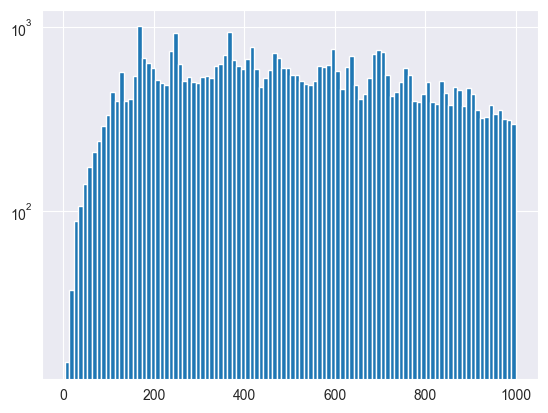

In [5]:
plt.hist(df_sim['dist'], bins=100, log=True);

# Randomly remove values

In [6]:
set_nans = False

In [7]:
# Randomly drop Gaia, Spitzer, 2MASS, or Wise photometry
gaia_cols = ['gaia_bp_phot', 'gaia_rp_phot', 'gaia_g_phot', 'parallax_obs']
tmass_cols = ['2mass_h', '2mass_j', '2mass_k']
spitzer_cols = ['irac_1', 'irac_2', 'irac_3', 'irac_4']
wise_cols = ['wise_1', 'wise_2', 'wise_3', 'wise_4']
phot_cols = [gaia_cols, tmass_cols, spitzer_cols, wise_cols]
# Random drop rate
drop_rate_gaia = 0.1
drop_rate_tmass = 0.2
drop_rate_spitzer = 0.9
drop_rate_wise = 0.5
drs = [drop_rate_gaia, drop_rate_tmass, drop_rate_spitzer, drop_rate_wise]

if set_nans:
    # Set values to nan
    for dr, cols in zip(drs, phot_cols):
        rows_to_nan_sim = np.random.choice(N, size=int(N * dr), replace=False)
        rows_to_nan_real = np.random.choice(N, size=int(N * dr), replace=False)
        # Set selected rows to NaN
        df_sim.loc[rows_to_nan_sim, cols] = np.nan
else:
    df_sim = df_sim.dropna().reset_index(drop=True)

In [8]:
# --- Define modalities and dimensions ---
modalities = ['xp', 'lamost', 'boss', 'apogee' , 'gaia_phot', '2mass_phot', 'wise_phot', 'spitzer_phot']
input_cols = {
    'xp': xp_cols,
    'lamost': lamost_cols,
    'boss': boss_cols,
    'apogee': apogee_cols,
    'gaia_phot': gaia_cols,
    '2mass_phot': tmass_cols,
    'wise_phot': wise_cols,
    'spitzer_phot': spitzer_cols,
}
input_dims = {
    'xp': len(xp_cols),
    'lamost': len(lamost_cols),
    'boss': len(boss_cols),
    'apogee': len(apogee_cols),
    'gaia_phot': len(gaia_cols),
    '2mass_phot': len(tmass_cols),
    'wise_phot': len(wise_cols),
    'spitzer_phot': len(spitzer_cols),
}
latent_dims = {
    'xp': 128,
    'lamost': 128,
    'boss': 128,
    'apogee': 128,
    'gaia_phot': 8,
    '2mass_phot': 8,
    'wise_phot': 8,
    'spitzer_phot': 8
}
trafo_dict = load_config('../simformer_config.json')
# --- Create toy data ---
key = jax.random.PRNGKey(0)
BATCH_SIZE = 2**10

# Store training data
sim_data = {mod: df_sim[input_cols[mod]].values for mod in modalities}
sim_data['theta'] = df_sim[feats_theta].values

# Normalize spectra

In [9]:
normalization_info = {}
sim_data_normed = {}
real_data_normed = {}
pair_data_normed = {}
test_data_normed = {}
spec_cols = ['xp', 'lamost', 'boss', 'apogee']

for mod in sim_data.keys():
    if mod in spec_cols:
        # Log normalization for spectra and normalize over entire spectra not per pixel
        log_mean_val = np.nanmean(np.log10(sim_data[mod]))
        log_std_val = np.nanstd(np.log10(sim_data[mod]))
        # Normalize values
        sim_mod_normed = (np.log10(sim_data[mod]) - log_mean_val) / log_std_val
        normalization_info[mod] = {'mean': log_mean_val, 'std': log_std_val, 'log': True}
        # Set
        sim_data_normed[mod] = sim_mod_normed
    else:
        mean_val = np.nanmean(sim_data[mod], axis=0)
        std_val = np.nanstd(sim_data[mod], axis=0)
        normalization_info[mod] = {'mean': mean_val, 'std': std_val, 'log': False}
        # Normalize values
        sim_mod_normed = (sim_data[mod] - mean_val) / std_val
        # Set
        sim_data_normed[mod] = sim_mod_normed

In [10]:
# for i in range(5):
#     _, bins, _ = plt.hist(sim_data_normed['theta'][:,i], bins=100, label='simulated', alpha=0.5, density=True, log=True)
#     plt.show()

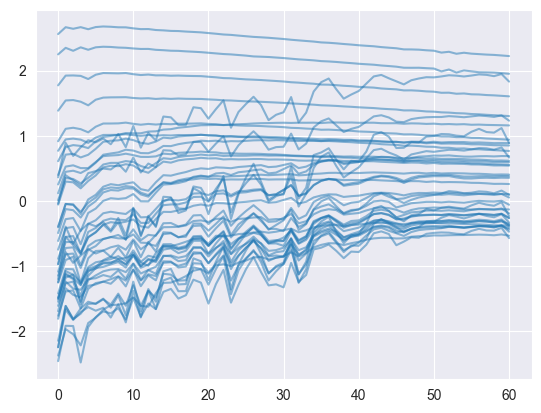

In [11]:
for i in range(18,59):
    plt.plot(sim_data_normed['xp'][i], label='simulated', c='C0', alpha=0.5)
# plt.legend()
plt.show()

# Concert into single JAX array

In [12]:
d_list = []
for mod, mod_arr in sim_data_normed.items():
    d_list.append(mod_arr)

data = jnp.asarray(np.concatenate(d_list, axis=1))[..., jnp.newaxis]

In [13]:
data.shape

(46327, 15120, 1)

# Set up training

In [14]:
# This creates the SDE for noise in diffusion model
# data_clean = data.copy()
# impute NaNs with 0 -> this is done for because "Independent" cannot handle NaNs
# but these values will be masked during training so it will not affect the learning
# data_clean = jnp.nan_to_num(data_clean, 0.0)

# === Model parameters ===
nodes_max = sum(latent_dims.values()) + len(feats_theta) #- (len(average_groups[0])-1) * latent_dims[list(average_groups[0])[0]]
model_init, model_fn = build_transformer_model(
    nodes_max=nodes_max,
    dim_value=trafo_dict['dim_value'],
    dim_id=trafo_dict['dim_id'],
    dim_condition=trafo_dict['dim_condition'],
    num_heads=trafo_dict['num_heads'],
    num_layers=trafo_dict['num_layers'],
    attn_size=trafo_dict['attn_size'],
    widening_factor=trafo_dict['widening_factor'],
    embed_time_dim=128
)

# Use a small batch to initialize the model
x0 = jnp.zeros((BATCH_SIZE, nodes_max, 1))
t = jnp.ones((BATCH_SIZE, 1))
node_ids = jnp.arange(nodes_max)
cond_mask = jnp.zeros_like(node_ids).astype(jnp.float32)
edge_mask = jnp.ones((BATCH_SIZE, nodes_max, nodes_max), dtype=bool)
params = model_init(key, t, x0, node_ids, cond_mask, edge_mask)

In [15]:
train_model = TrainFlowModel(
    key=key,
    data=data,                        # shape (N, T, 1)
    model_fn=model_fn,                # Haiku-transformed apply fn
    params=params,
    nodes_max=data.shape[1],
    batch_size=1024,
    lr=1e-3,
    inner_train_loop_size=1,
    early_stopping_patience=30,
    model_check_point_dir="./checkpoints"  # optional
)

In [ ]:
best_params = train_model.fit(epochs=2)

In [ ]:
# Sample from the model

In [ ]:
cond_arr = []
for mod, mod_arr in sim_data_normed.items():
    if mod == 'theta':
        # For theta, we use the mean and std of the training data
        means = normalization_info[mod]['mean']
        stds = normalization_info[mod]['std']
    else:
        # For spectra, we use the log mean and std
        means = normalization_info[mod]['mean']
        stds = normalization_info[mod]['std']
    cond_val_arr = jnp.zeros(mod_arr.shape[1], dtype=int)
    cond_arr.append()

In [ ]:
shape = (2**10,)
# dim2keep = 1
all_node_ids = jnp.arange(data.shape[1])
condition_mask = jnp.array([0, 0, 0], dtype=int)
condition_value = jnp.zeros((3,))
node_ids_fit = jnp.array([0, 1, 2], dtype=int)  # shape (B, T)
edge_mask = jnp.ones((3,3), dtype=bool)  # shape (B, T, T)
dim2keep = 1
marginal_ids = all_node_ids != dim2keep  # shape (B, T)
condition_value = condition_value.at[marginal_ids].set(1000.)  # shape (B, T)
# Set edge mask to False for all marginal nodes
edge_mask = edge_mask.at[marginal_ids[:, None] | marginal_ids[None, :]].set(False)

marginal_samples = pure_batched_sampler(
    train_model.model_fn,                         # static
    train_model.opt_params,                       # static
    key,
    shape,                               # shape tuple, not an integer
    condition_mask,                               # (B, T)
    condition_value,                              # (B, T)
    # jnp.tile(jnp.arange(dim)[None], (num_samples, 1)),  # (B, T)
    node_ids_fit,
    edge_mask,                                    # (B, T, T)
    64,                                           # steps (static)
    0.0,                                          # t0
    1.0,                                          # t1
)
marginal_samples_denorm = (marginal_samples * stds[node_ids_fit]) + means[node_ids_fit]